### Setup

In [22]:
import tensorflow as tf

In [23]:
tf.__version__

'2.6.2'

In [24]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [25]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [26]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [27]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [28]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [29]:
def make_generator_model():
    # Initialize a sequential model
    model = tf.keras.Sequential()
    
    # Add a densely connected layer with 7*7*256 units, no bias, and a 100-dimensional input
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # Add batch normalization
    model.add(layers.BatchNormalization())
    # Add LeakyReLU activation
    model.add(layers.LeakyReLU())

    # Reshape the output to (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    # Assert the output shape
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # Add a transposed convolutional layer with 128 filters, 5x5 kernel, stride 1, same padding, no bias
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Assert the output shape
    assert model.output_shape == (None, 7, 7, 128)
    # Add batch normalization
    model.add(layers.BatchNormalization())
    # Add LeakyReLU activation
    model.add(layers.LeakyReLU())

    # Add another transposed convolutional layer with 64 filters, 5x5 kernel, stride 2, same padding, no bias
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Assert the output shape
    assert model.output_shape == (None, 14, 14, 64)
    # Add batch normalization
    model.add(layers.BatchNormalization())
    # Add LeakyReLU activation
    model.add(layers.LeakyReLU())

    # Add a final transposed convolutional layer with 1 filter, 5x5 kernel, stride 2, same padding, no bias
    # Use tanh activation for pixel values in the range [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # Assert the output shape
    assert model.output_shape == (None, 28, 28, 1)

    return model

'''
    Densely Connected Layer (Input Layer):
        This layer serves as the input layer of the generator neural network.
        It consists of 77256 units, which are densely connected to the 100-dimensional input vector.
        The use_bias parameter is set to False, meaning there are no bias terms added.
        It initializes the generation process by mapping the input noise vector to a higher-dimensional space.

    Batch Normalization:
        Batch normalization is applied after the dense layer to stabilize and speed up the training process.
        It normalizes the activations of the previous layer for each batch, ensuring that the network trains faster and is more stable during training.

    LeakyReLU Activation:
        Leaky ReLU (Rectified Linear Unit) is an activation function that allows a small, positive gradient when the unit is not active (i.e., when the input is negative).
        It helps alleviate the vanishing gradient problem and enables the model to learn even when some units are not activated.
        f(x)=max(ax,x) where a is a small constant(0.01).

    Reshape Layer:
        Reshapes the output of the previous layer into a 3D tensor of shape (7, 7, 256).
        This prepares the data for the subsequent transposed convolutional layers.

    Conv2DTranspose Layer (Transposed Convolutional Layer 1):
        Transposed convolutional layer with 128 filters and a 5x5 kernel.
        It upsamples the input tensor from a lower resolution (7x7) to a higher resolution (14x14).
        The strides parameter is set to (1, 1), maintaining the spatial dimensions.
        Batch normalization and LeakyReLU activation are applied afterward to introduce non-linearity and stabilize training.

    Conv2DTranspose Layer (Transposed Convolutional Layer 2):
        Another transposed convolutional layer with 64 filters and a 5x5 kernel.
        It further upsamples the tensor from 14x14 to 28x28, doubling the spatial dimensions.
        The strides parameter is set to (2, 2) to achieve the upsampling effect.
        Batch normalization and LeakyReLU activation are applied afterward for non-linearity and stabilization.

    Conv2DTranspose Layer (Output Layer):
        Final transposed convolutional layer with 1 filter and a 5x5 kernel.
        It produces the output image with a resolution of 28x28 pixels.
        The tanh activation function is used to ensure the pixel values are in the range [-1, 1], suitable for image data.
        No batch normalization is applied after this layer, as it's the output layer.
'''


"\n    Densely Connected Layer (Input Layer):\n        This layer serves as the input layer of the generator neural network.\n        It consists of 77256 units, which are densely connected to the 100-dimensional input vector.\n        The use_bias parameter is set to False, meaning there are no bias terms added.\n        It initializes the generation process by mapping the input noise vector to a higher-dimensional space.\n\n    Batch Normalization:\n        Batch normalization is applied after the dense layer to stabilize and speed up the training process.\n        It normalizes the activations of the previous layer for each batch, ensuring that the network trains faster and is more stable during training.\n\n    LeakyReLU Activation:\n        Leaky ReLU (Rectified Linear Unit) is an activation function that allows a small, positive gradient when the unit is not active (i.e., when the input is negative).\n        It helps alleviate the vanishing gradient problem and enables the model

Use the (as yet untrained) generator to create an image.

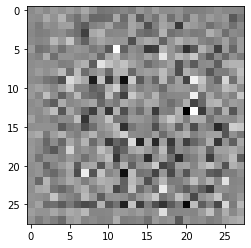

In [30]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [31]:
def make_discriminator_model():
    # Initialize a sequential model
    model = tf.keras.Sequential()
    
    # Add a convolutional layer with 64 filters, 5x5 kernel, stride 2, same padding
    # Input shape is [28, 28, 1], representing 28x28 grayscale images
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                             input_shape=[28, 28, 1]))
    # Add LeakyReLU activation
    model.add(layers.LeakyReLU())
    # Add dropout layer with a dropout rate of 0.3 to prevent overfitting
    model.add(layers.Dropout(0.3))

    # Add another convolutional layer with 128 filters, 5x5 kernel, stride 2, same padding
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # Add LeakyReLU activation
    model.add(layers.LeakyReLU())
    # Add dropout layer with a dropout rate of 0.3 to prevent overfitting
    model.add(layers.Dropout(0.3))

    # Flatten the output to feed into a dense layer
    model.add(layers.Flatten())

    # Add a dense layer with a single unit (outputting a single scalar value)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

'''
Assigns probability of whether image is fake or real
'''

'\nAssigns probability of whether image is fake or real\n'

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [32]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4993638]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [33]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [34]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [38]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [39]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [41]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

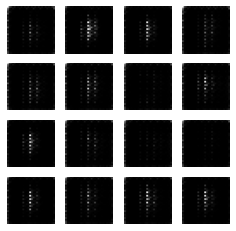

Time for epoch 1 is 249.88201999664307 sec


KeyboardInterrupt: 

In [42]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))